In [1]:
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import preprocess



In [2]:
import cv2
from sklearn.utils import shuffle
from scipy.misc import imread 
import matplotlib.pyplot as plt
%matplotlib inline

(sizex,sizey) = preprocess.size()

def generator(log):
    
    shown = False
    
    BS = 4
    while True:
        log = shuffle(log)
        for centerfiles, rightfiles, leftfiles, steerings in \
            zip(log['center'].values.reshape(-1,BS), 
                log['right'].values.reshape(-1,BS), 
                log['left'].values.reshape(-1,BS), 
                log['steering'].values.reshape(-1,BS)):
                
            images              = np.zeros((BS*2, sizey, sizex, 3), dtype=np.uint8)
            augmented_steerings = np.zeros((BS*2), dtype=np.float32)

            for i, (centerfile, rightfile, leftfile, steering) in enumerate(zip(centerfiles, rightfiles, leftfiles, steerings)):
                centerimage         = preprocess.preprocess(imread('data/' + centerfile.strip()))
                rightimage          = preprocess.preprocess(imread('data/' + rightfile.strip()))
                leftimage           = preprocess.preprocess(imread('data/' + leftfile.strip()))

                
                if shown==False:
                    print(imread('data/' + centerfile.strip()).shape)
                    plt.imshow(cv2.cvtColor(centerimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()
                    plt.imshow(cv2.cvtColor(rightimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()
                    plt.imshow(cv2.cvtColor(leftimage, cv2.COLOR_YCrCb2RGB))
                    plt.show()

                    shown=True

                    
                images[i]                   = centerimage
                augmented_steerings[i]      = steering
                images[i+BS]                = cv2.flip(centerimage, flipCode = 1)
                augmented_steerings[i+BS]   = -steering

                '''
                steering_correction = 0.17

                if ((steering - steering_correction) > -1.):
                    images[i+BS]                = rightimage
                    augmented_steerings[i+BS]   = steering - steering_correction
                else:
                    images[i+BS]                = centerimage
                    images[i+BS*2]              = steering

                if ((steering + steering_correction) < 1.):
                    images[i+BS*2]              = leftimage
                    augmented_steerings[i+BS*2] = steering + steering_correction
                else:
                    images[i+BS*2]              = centerimage
                    augmented_steerings[i+BS*2] = steering 
                    '''
            yield (images, augmented_steerings)



![Nvidia CNN architecture](http s://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

In [3]:

from model import get_model

model = get_model()


Using TensorFlow backend.


Epoch 1/4
(160, 320, 3)


/home/antor/CarND-p3/preprocess.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  image = image[leny * .35 : leny *.85 ,:]


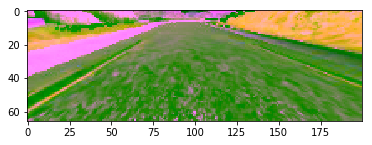

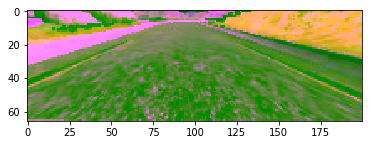

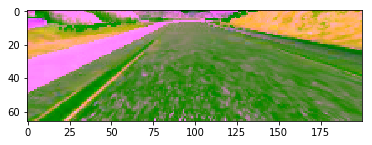

6420/6428 [============================>.] - ETA: 0s - loss: 0.0384 - mean_squared_error: 0.0384   

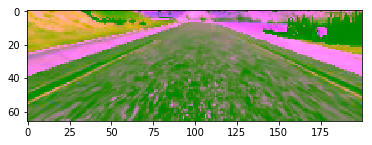

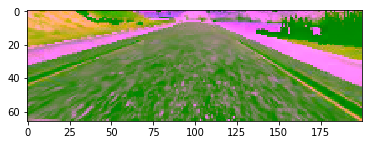

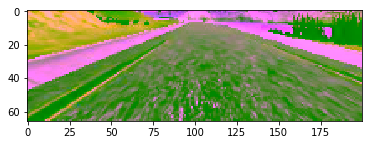

6428/6428 [==============================] - 25s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2/4
6428/6428 [==============================] - 23s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0123 - val_mean_squared_error: 0.0123

In [4]:
# Train the model
# History is a record of training loss and metrics
driving_log = pd.read_csv('data/driving_log.csv')

from sklearn.model_selection import train_test_split

train_log, validate_log = train_test_split(driving_log, test_size=0.20)

history = model.fit_generator(generator(train_log), 
            nb_epoch=4, 
            samples_per_epoch = train_log.shape[0]*2,
            validation_data = generator(validate_log),
            nb_val_samples = validate_log.shape[0]*2)




In [6]:
from keras.models import model_from_json
#from keras.models import save_weights

name = 'comma'

with open(name + ".json", "w") as file:
    file.write(model.to_json())

model.save_weights(name + '.h5')

